In [2]:
# imports
import pandas as pd
from pandas import DataFrame, Series
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn
import os
import string
from PIL import Image

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Create a mapping from the image files to the character they represents
character_list = list(string.digits + string.ascii_uppercase + string.ascii_lowercase)
nums = range(1,len(character_list)+1)
file_to_character = dict(zip(nums, character_list))

In [10]:
# Take the median size of the images as the standard_size for 
# normalization of the images
path = '/home/reza/MachineLearning/Hand-Writing-Recognition/data/English/img/'
img_sizes = []
for folder in os.listdir(path):
    for img_file in os.listdir(path+'/'+folder+'/'):
        img = Image.open(path+'/'+folder+'/'+img_file)
        img_sizes.append(img.size)

# resize function only takes int values
STANDARD_SIZE = map(int, median(img_sizes, axis=0))

In [6]:
# Create an image class that allows us to represent the image in matrix or vector from
class img():
    def __init__(self, img_file=None, img_path=None):
        if img_file is None or img_path is None:
            raise Exception('Must give an image file as input along'
                            'with its file name')
        self.img_matrix = None
        self.img_vector = None
        self.img_label = None
        self.img_file = img_file
        self.img_path = img_path
        
    def img_to_matrix(self):
        """
        Extract a matrix representation of the image
        """
        # Resize the image to a standard size
        img_resized = self.img_file.resize(STANDARD_SIZE)
        self.img_matrix = array(img_resized)

    def flatten_image(self):
        """
        Flatten the matrix representation of the image. If the
        matrix has shape (m, n) then the vector representation
        has shape (1, m * n)
        """
        if self.img_matrix is None:
            self.img_to_matrix()
        s = self.img_matrix.shape[0] * self.img_matrix.shape[1]
        self.img_vector = self.img_matrix.reshape(1, s)[0]

    def get_img_label(self):
        """"
        Sets the label for the image file, i.e, the English
        character the image is showing
        """
        file_name = self.img_path.split('/')[-1][3:6]
        self.img_label = file_to_character[int(file_name)]
        
# img1 = img(img_file=img_file, img_path='blahblah/im-001')
# img1.img_label
# img1.img_to_matrix()
# print img1.img_matrix
# img1.flatten_image()
# img1.img_vector
# img1.get_img_label()
# img1.img_label


In [7]:
# Gather features of the image for building the training data
path = '/home/reza/MachineLearning/Hand-Writing-Recognition/data/English/img/'
data = []
labels = []
for folder in os.listdir(path):
    for img_file in os.listdir(path+'/'+folder+'/'):
        img_file = Image.open(path+'/'+folder+'/'+img_file)
        img_path = img_file.filename
        img_file = img_file.convert('L')
        
        # Open in the image file
#         img_file = img_file.convert("L").filter(ImageFilter.GaussianBlur(radius = 2))
        curr_img = img(img_file=img_file, img_path=img_path)
        
        # Take a vectore representation of the image
        curr_img.flatten_image()
        data.append(curr_img.img_vector)
        
        # add the label
        curr_img.get_img_label()
        labels.append(curr_img.img_label)

data = np.array(data)

In [8]:
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import cross_validation
from sklearn.cross_validation import cross_val_score
from sklearn import svm

# Create the training data
pca = PCA(n_components=50)
X = pca.fit_transform(data)
df = DataFrame(X)
response = 'label'
df[response] = labels

# Divide data to test and train
mask = np.random.rand(len(df)) < 0.85
train_dat = df[mask]
test_dat = df[~mask]
y_test = np.array(test_dat[response])
test_dat.drop(response, axis=1, inplace=True)


/home/reza/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [9]:
# Run random forest on the train model and pick the number
# of trees used for the model
rf = RandomForestClassifier(n_estimators=1000, oob_score=True)
rf.fit(train_dat.drop(response, axis=1), train_dat[response])
prediction = rf.predict(test_dat)

# Check error percentage on the test set and tune parameters
mean(prediction != y_test)

0.42517605633802819

In [124]:
# Lets test this on a sample image
path = '/home/reza/Downloads/test.jpg'
img_file = Image.open(path)
img_path = img_file.filename
img_file = img_file.convert('L')
        
# Open in the image file
img_file = img_file.convert("L").filter(ImageFilter.GaussianBlur(radius = 2))
curr_img = img(img_file=img_file, img_path=img_path)
        
# Take a vectore representation of the image
curr_img.flatten_image()
test_point = pca.transform(curr_img.img_vector)

# Predict the label for the test point
rf.predict(test_point)

array(['N'], dtype=object)

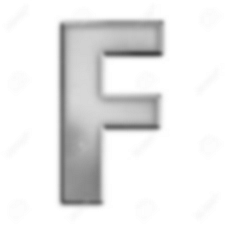

In [55]:
from PIL import ImageFilter
img_file.filter(ImageFilter.SHARPEN)


## Using a different Dataset for Handwriting Recognition

In [3]:
# Read the symbols in the data
path = '/home/reza/MachineLearning/Hand-Writing-Recognition/data/coordinate/'
symbols = pd.read_csv(path+'symbols.csv', error_bad_lines=False, delimiter=';')

# Create a mapping from the symbol to the character it represents
id_to_char = dict(zip(symbols.symbol_id.astype(str), symbols.latex))

In [252]:
import csv
import json

# Create a dictionary with keys alphanumeric characters
# and values strokes. Each stroc consists of a set of 
# (x,y,t) coordinates
recordings = []
with open(path+'train-data.csv', 'rb') as csvfile:
    data = csv.reader(csvfile, delimiter=';')
    next(data, None)
    for row in data:
        symbol = id_to_char[row[0]]
        if symbol.isalnum():
            record = dict()
            record[symbol] = json.loads(row[2])
            recordings.append(record)

In [8]:
# Find the distribution distance between strokes
def find_dist(x,y):
    x = np.array([x['x'], x['y']])
    y = np.array([y['x'], y['y']])
    return sqrt(sum((x-y)**2))
    
stroke_dist = []
for record in recordings:
    strokes = record[record.keys()[0]]
    for i in range(1, len(strokes)):
        # current point
        s_curr = strokes[i][0]
        
        # previous point
        s_prev = strokes[i-1][-1]
        stroke_dist.append(find_dist(s_curr, s_prev))


(array([ 203.,  210.,  385.,  393.,  352.,  193.,   86.,   37.,   10.,    5.]),
 array([   0.        ,   36.49657492,   72.99314984,  109.48972476,
         145.98629967,  182.48287459,  218.97944951,  255.47602443,
         291.97259935,  328.46917427,  364.96574918]),
 <a list of 10 Patch objects>)

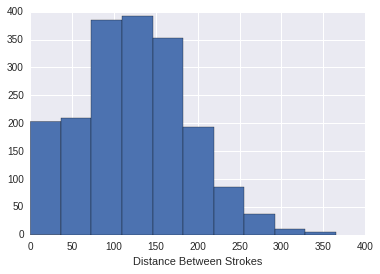

In [222]:
# Plot the distribution of distance between strokes
plt.xlabel('Distance Between Strokes')
plt.hist(stroke_dist)

In [223]:
# Find some stats on distance between strokes
threshold = 10
percent_low_dist = len(filter(lambda x: x < threshold, stroke_dist))/float(len(stroke_dist)) * 100
print 'There are %{} of the strokes with distance less than {}'.format(percent_low_dist, threshold)

There are %4.64247598719 of the strokes with distance less than 10


In [437]:
# Find the distribution of speed betweeen consecutive points
points_speed = []
for record in recordings:
    strokes = record[record.keys()[0]]
    for stroke in strokes:
        for i in range(1, len(stroke)):
            speed = find_dist(stroke[i], stroke[i-1])/float(stroke[i]['time'])
            points_speed.append(speed)
            

(array([  3.23520000e+05,   1.10000000e+01,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 9 Patch objects>)

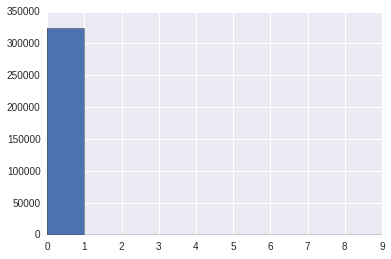

In [445]:
# Plot the distribution of the speed between consecutive points
plt.hist(points_speed, bins=range(10))

In [254]:
# Find the distribution of number of strokes
num_strokes = []
for record in recordings:
    num_strokes.append(len(record[record.keys()[0]]))

(array([  2.68400000e+03,   1.13900000e+03,   2.95000000e+02,
          0.00000000e+00,   2.90000000e+01,   5.00000000e+00,
          0.00000000e+00,   5.00000000e+00,   1.00000000e+00,
          1.00000000e+00]),
 array([ 1. ,  1.7,  2.4,  3.1,  3.8,  4.5,  5.2,  5.9,  6.6,  7.3,  8. ]),
 <a list of 10 Patch objects>)

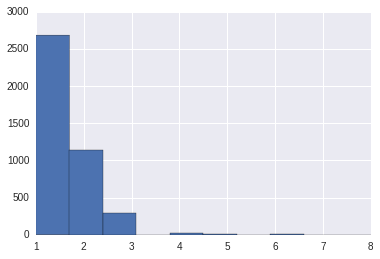

In [255]:
# Plot the distribution of number of strokes
plt.hist(num_strokes)

In [464]:
# Find some stats on distance between strokes
threshold = 3
percent_low_dist = len(filter(lambda x: x > threshold, points_speed))/float(len(stroke_dist)) * 100
print 'There are %{} of the control points with distance greater than {}'.format(percent_low_dist, threshold)

There are %0.0 of the control points with distance greater than 3


In [270]:
from scipy.interpolate import interp1d

# Some configuration needed for modifying the drawing record
FACTOR_CORRECTION = 0.00001
STOROKE_CONNECT_THERESHOLD=10
SMOOTHING_WEIGHT = 1.0/3
DEHOOK_THRESHOLD = 3
DEHOOK_ANGLE_THRESHOLD_BEG = 30
DEHOOK_ANGLE_THRESHOLD_END = 30
RESAMPLING_STROKE_THRESHOLD = 4
NUM_RESAMPLE = 1000
STROKE_PARTITION = 20
NUM_STROKES_AS_FEATURE = 3

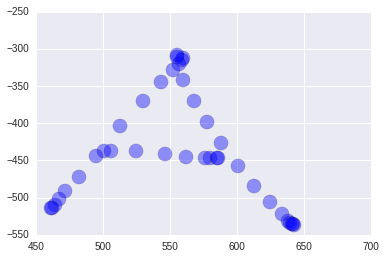

9.86707180554 beg
63.4352993563 dehooked end
6.01085984818 end
11.3116456473 beg
179.736109137 dehooked end
0.263890862973 end
0.128789685233 beg
0.280689678906 end


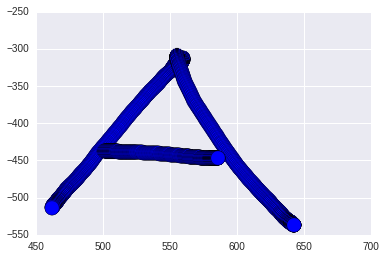

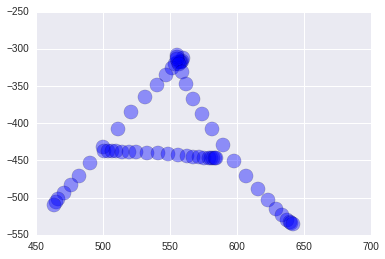

[[{'time': 1400928965480.0, 'x': 560.0, 'y': 312.00000000000057},
  {'time': 1400928965480.2202, 'x': 559.98388671875, 'y': 312.12499333428},
  {'time': 1400928965480.4404, 'x': 559.9677734375, 'y': 312.2481504497088},
  {'time': 1400928965480.6606, 'x': 559.95166015625, 'y': 312.3694849358937},
  {'time': 1400928965480.8809, 'x': 559.935546875, 'y': 312.4890103824414},
  {'time': 1400928965481.1011, 'x': 559.91943359375, 'y': 312.6067403789588},
  {'time': 1400928965481.3213, 'x': 559.9033203125, 'y': 312.72268851505294},
  {'time': 1400928965481.5415, 'x': 559.88720703125, 'y': 312.8368683803304},
  {'time': 1400928965481.7617, 'x': 559.87109375, 'y': 312.9492935643982},
  {'time': 1400928965481.9819, 'x': 559.85498046875, 'y': 313.05997765686317},
  {'time': 1400928965482.2021, 'x': 559.8388671875, 'y': 313.1689342473321},
  {'time': 1400928965482.4224, 'x': 559.82275390625, 'y': 313.2761769254119},
  {'time': 1400928965482.6426, 'x': 559.806640625, 'y': 313.3817192807093},
  {'time

In [288]:
# Create a class drawing_record that has methods to
# handle each record (scaling, resampling, feature extraction)
class drawing_record():
    def  __init__(self, strokes):
        self.strokes = strokes
        self.features = []
        self.sample_stroke = []
    
    def remov_None_strokes(self):
        """
        Clean the strokes for None values
        """
        cleaned = []
        for stroke in self.strokes:
            if stroke is not None:
                cleaned.append(stroke)
        self.strokes = cleaned
    
    def wild_filter(self):
        """
        Remove points with high speed (caused by hardware error)
        """
        pass
        
    def stroke_connect(self):
        """
        Connects two srokes if the distance betwen them
        is unusualy close
        """
        # If there is only one stroke do nothing
        if len(self.strokes) < 2:
            return
        
        connected = []
        i, n = 0, len(self.strokes)
        while i < n:
            temp = self.strokes[i]
            while i+1<n and find_dist(temp[-1], self.strokes[i+1][0]) < STOROKE_CONNECT_THERESHOLD:
                print 'connection happened'
                temp = temp + self.strokes[i+1]
                i+=1
            connected.append(temp)
            i += 1
        self.strokes = connected 
    
    def dehook(self, beg=False, end=False):
        """
        Removes hooks at the begining or end of a stroke
        """
        if not beg and not end:
            print 'Dehooking was not done, set beg or end to True'
            return
        # Given three points p0,p1,p2 in order, it calculates
        # the angle between p_10 and p_21
        def calculate_angle(points):
            # Return euclidean distance between two points
            def diff(v,w):
                v = np.array([v['x'], v['y']])
                w = np.array([w['x'], w['y']])
                return v-w
            p_10 = diff(points[0], points[1])
            p_21 = diff(points[1], points[2])
            # Find the cosine of the angle
            cos_angle = float(p_10.dot(p_21))/((sqrt(p_10.dot(p_10)) + 
                                                FACTOR_CORRECTION) * 
                                               (sqrt(p_21.dot(p_21)) +
                                                FACTOR_CORRECTION))
            angle = arccos(cos_angle) * 180/pi
            return angle
        
        # Dehooks at the begining
        def dehook_stroke_beg(index):
            if len(self.strokes[i]) < DEHOOK_THRESHOLD:
                print 'There are not enough points in the stroke to dehook'
                return
            three_points = self.strokes[i][index:index+3]
            if calculate_angle(three_points) < DEHOOK_ANGLE_THRESHOLD_BEG:
                print calculate_angle(three_points), 'beg'
                return self.strokes[i][index:]
            else:
                print calculate_angle(three_points), 'dehooked', 'beg'
                return dehook_stroke_beg(index+1)

        # Dehooks at the end
        def dehook_stroke_end(index):
            if len(self.strokes[i]) < DEHOOK_THRESHOLD:
                print 'There are not enough points in the stroke to dehook'
                return
            three_points = self.strokes[i][index-2:index] + [self.strokes[i][index]]
            if calculate_angle(three_points) < DEHOOK_ANGLE_THRESHOLD_END:
                print calculate_angle(three_points), 'end'
                return self.strokes[i][:index] + [self.strokes[i][index]]
            else:
                print calculate_angle(three_points), 'dehooked', 'end'
                return dehook_stroke_end(index-1)
        
        for i, stroke in enumerate(self.strokes):
            if beg:
                dehook_beg = dehook_stroke_beg(0)
                if dehook_beg is not None:
                    self.strokes[i] = dehook_beg
            if end:
                dehook_end = dehook_stroke_end(-1)
                if dehook_end is not None:
                    self.strokes[i] = dehook_end
    
    def average_smoothing(self):
        """
        Smooths every stroke using a weighted average.
        """
        smoothened = []
        for stroke in self.strokes:
            smoothened.append([stroke[0]])
            for i in range(1, len(stroke)-1):
                p = {'time':0, 'x':0, 'y':0}
                for point in [stroke[i-1], stroke[i], stroke[i+1]]:
                    p['time'] += point['time']
                    p['x'] += point['x']
                    p['y'] += point['y']
                p = dict(map(lambda (x,y): (x,int(round(y*SMOOTHING_WEIGHT,2))),
                             p.items()))
                smoothened[-1].append(p)
            smoothened[-1].append(stroke[-1])
        self.strokes = smoothened
        
    def find_bounding_box(self):
        """
        Find the bounding box of the drawing character
        """
        mint, minx, miny = [float('inf')]*3
        maxx, maxy, maxt = [float('-inf')]*3
        for stroke in self.strokes:
            for point in stroke:
                if point['time'] < mint:
                    mint = point['time']
                if point['x'] < minx:
                    minx = point['x']
                if point['y'] < miny:
                    miny = point['y']
                if point['x'] > maxx:
                    maxx = point['x']
                if point['y'] > maxy:
                    maxy = point['y']
        return (mint, minx, maxx, miny, maxy)

    def scale_shift(self):
        """
        Scale and shif the coordinates of the drawing.
        Only the smaller dimension gets centered
        """
        mint, minx, maxx, miny, maxy = self.find_bounding_box()
        for stroke in self.strokes:
            for point in stroke:
                width = (maxx-minx) + FACTOR_CORRECTION
                height = (maxy-miny) + FACTOR_CORRECTION
                fx = 1.0/width
                fy = 1.0/height
                f = min(fx,fy)
                add = min(width, height)/2.0 * f
                addx, addy = 0, 0
                if f == fx:
                    addx = add
                else:
                    addy = add
                point['x'] = (point['x'] - minx) * f - addx
                point['y'] = (point['y'] - miny) * f - addy
                point['time'] = point['time'] - mint

    def resample(self):
        """
        Use interpolation to fill in the missing x and y
        values.
        """
        resampled = []
        for stroke in self.strokes:
            if len(stroke) < RESAMPLING_STROKE_THRESHOLD:
                continue
            resampled.append([])
            x, y, t = [], [], []
            for point in stroke:
                x.append(point['x'])
                y.append(point['y'])
                t.append(point['time'])
            f_x = interp1d(t, x)
            f_y = interp1d(t, y, kind='cubic')
            time_interval = linspace(t[0], t[-1], num=NUM_RESAMPLE)
            for t_ in time_interval:
                p = {'time':0, 'x':0, 'y':0}
                p['time'] = t_
                p['x'] = float(f_x(t_))
                p['y'] = float(f_y(t_))
                resampled[-1].append(p)
        self.strokes = resampled
    def plot_drawing(self, strokes):
        x_val = []
        y_val = []
        for stroke in strokes:
            for point in stroke:
                x_val.append(point['x'])
                y_val.append(-point['y'])
        plt.scatter(x_val, y_val, s=200, alpha=0.4)
        plt.show(block=False)
    
    def extract_feature(self):
        """
        This takes a fixed number of points from each stroke
        as features. There are 3 strokes to consider. If a 
        character has less strokes value 0 is used as missing
        values.
        """
        features = []
        for i, stroke in enumerate(self.strokes):
            if i < NUM_STROKES_AS_FEATURE:
                x_vals = map(lambda x: x['x'], stroke[::len(stroke)/STROKE_PARTITION])
                y_vals = map(lambda x: x['y'], stroke[::len(stroke)/STROKE_PARTITION])
                self.sample_stroke.append(stroke[::len(stroke)/STROKE_PARTITION])
                features = features + x_vals
                features = features + y_vals
        self.features = features
        
num = 4
dr = drawing_record(recordings[num][recordings[num].keys()[0]])
dr.remov_None_strokes()
dr.plot_drawing(dr.strokes)
dr.stroke_connect()
dr.dehook(beg=True, end=True)
dr.average_smoothing()
dr.resample()
# dr.scale_shift()
dr.extract_feature()
dr.plot_drawing(dr.strokes)
dr.plot_drawing(dr.sample_stroke)

dr.strokes

connection happened
connection happened
connection happened
connection happened
connection happened
connection happened
connection happened
connection happened
connection happened
connection happened
connection happened
connection happened
connection happened
connection happened
connection happened
connection happened
connection happened
connection happened
connection happened
connection happened
connection happened
connection happened
connection happened
connection happened
connection happened
connection happened
connection happened
connection happened
connection happened
connection happened
connection happened
connection happened
connection happened
connection happened
connection happened
connection happened
connection happened
connection happened
connection happened
connection happened
connection happened
connection happened
connection happened
connection happened
connection happened
connection happened
connection happened
connection happened
connection happened
connection happened


(array([  2.70300000e+03,   1.16000000e+03,   0.00000000e+00,
          2.74000000e+02,   0.00000000e+00,   1.40000000e+01,
          4.00000000e+00,   0.00000000e+00,   3.00000000e+00,
          1.00000000e+00]),
 array([ 1. ,  1.6,  2.2,  2.8,  3.4,  4. ,  4.6,  5.2,  5.8,  6.4,  7. ]),
 <a list of 10 Patch objects>)

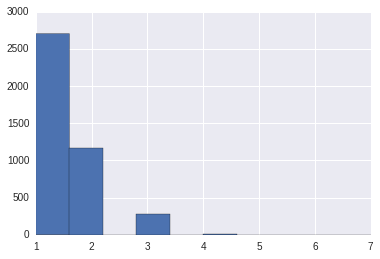

In [257]:
# Find the distribution of number of strokes after
# removing None strokes and performing stroke connect
num_strokes = []
for record in recordings:
    dr = drawing_record(record[record.keys()[0]])
    dr.remov_None_strokes()
    dr.stroke_connect()
    num_strokes.append(len(dr.strokes))
# Plot the distribution of number of strokes
plt.hist(num_strokes)

In [493]:
# for i in range(200000):
#     for key, _ in recordings[i].items():
#         if len(recordings[i][key]) == 3:
#             print i
#             break

In [494]:
# for j, record in enumerate(recordings):
#     strokes = record[record.keys()[0]]
#     for i in range(1, len(strokes)):
#         # current point
#         s_curr = strokes[i][0]
        
#         # previous point
#         s_prev = strokes[i-1][-1]
#         if find_dist(s_curr, s_prev) < 10:
#             print j
#             break


In [274]:
a = range(40)
a
a[::2]

[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38]